# this notebook is just for testing

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [193]:
import os
import subprocess
import json
import numpy as np
import matplotlib.pyplot as pl
import tkinter as tk #to import file
from tkinter import filedialog #to open import dialog

In [56]:
def print_info(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)
    print(jout)
            
def get_bitrate(file):
    command = f"ffprobe -v error -select_streams v:0 -show_entries format:stream -print_format json {file}"
    cout = subprocess.run(command.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout
    jout = json.loads(cout)  # Convert data from JSON string to dictionary
    return int(jout["format"]["bit_rate"])

def get_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs0.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/temp_vmaf_logs.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    return i_data["pooled_metrics"]["vmaf"]["mean"]

f_ref = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_FullHD/SVT/mux_10sec_25.y4m"
f_dist = "rush_AVC_5pts"
print_info("/home/ubuntu/video_dynopt/tests_vids/srcRAW_4K/bar_dinner.y4m")

plot = {"PLOT": False, "FX": True, "BF": False, "LG": False, "CF": False, "TARGET": "rate"}

if plot["PLOT"]:
    my_dpi = 96
    pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)

    if plot["FX"]:
        folder = "tests_vids/testAV1/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-b', label="Fixed CRF")

    if plot["BF"]:
        folder = "tests_vids/testVP9/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-g', label="Single shot")

    if plot["LG"]:
        folder = "tests_vids/OPT_vids/"+f_dist+"/lg_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-c', label="OPT lg")

    if plot["CF"]:
        folder = "tests_vids/OPT_vids/"+f_dist+"/cf_"+plot["TARGET"]+"/"
        rate = np.zeros(len(os.listdir(folder)))
        dist = np.zeros(len(os.listdir(folder)))
        i = 0
        for vid in sorted(os.listdir(folder)):
            rate[i] = get_bitrate(folder + vid)
            dist[i] = get_vmaf(folder + vid,f_ref)
            i += 1
        print(rate)
        print(dist)
        pl.plot(rate/1000, dist, '-r', label="OPT cf")

    pl.grid(True)
    pl.title("RQ \"bar\" - AVC 1080p")
    pl.ylabel("Quality (VMAF)")
    pl.xlabel("Bitrate (Kbit/s)")
    pl.legend(loc="lower right")
    pl.figure()


{'programs': [], 'streams': [{'index': 0, 'codec_name': 'rawvideo', 'codec_long_name': 'raw video', 'codec_type': 'video', 'codec_tag_string': 'I420', 'codec_tag': '0x30323449', 'width': 4096, 'height': 2160, 'coded_width': 4096, 'coded_height': 2160, 'closed_captions': 0, 'film_grain': 0, 'has_b_frames': 0, 'sample_aspect_ratio': '1:1', 'display_aspect_ratio': '256:135', 'pix_fmt': 'yuv420p', 'level': -99, 'color_range': 'tv', 'chroma_location': 'center', 'field_order': 'progressive', 'refs': 1, 'r_frame_rate': '30/1', 'avg_frame_rate': '30/1', 'time_base': '1/30', 'start_pts': 0, 'start_time': '0.000000', 'duration_ts': 1201, 'duration': '40.033333', 'disposition': {'default': 0, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impaired': 0, 'clean_effects': 0, 'attached_pic': 0, 'timed_thumbnails': 0, 'captions': 0, 'descriptions': 0, 'metadata': 0, 'dependent': 0, 'still_image': 0}}], 'format': {'filename': '/home/ubuntu/

In [108]:
start_t = end_t = 0.0
p = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_FullHD/SVT/mux_10sec_25.y4m"
with open("/home/ubuntu/video_dynopt/config/tmp_shot_dect_955828.log", 'r') as r:
    tm_log = r.read().splitlines()[::2]
tm_log.append("end pts_time:" + str(50.08))
for i,l in enumerate(tm_log): #for each cut
    end_t = l.split("pts_time:",1)[1]
    print(start_t,end_t)
    cut = f"ffmpeg -ss {start_t} -to {end_t} -i {p} -hide_banner -loglevel error\
        -pix_fmt yuv420p tests_vids/shot_{str(i)}.y4m"
    subprocess.call(cut, shell=True)
    start_t = end_t

0.0 10.08
10.08 20.08
20.08 30.08
30.08 40.08
40.08 50.08


<Figure size 432x288 with 0 Axes>

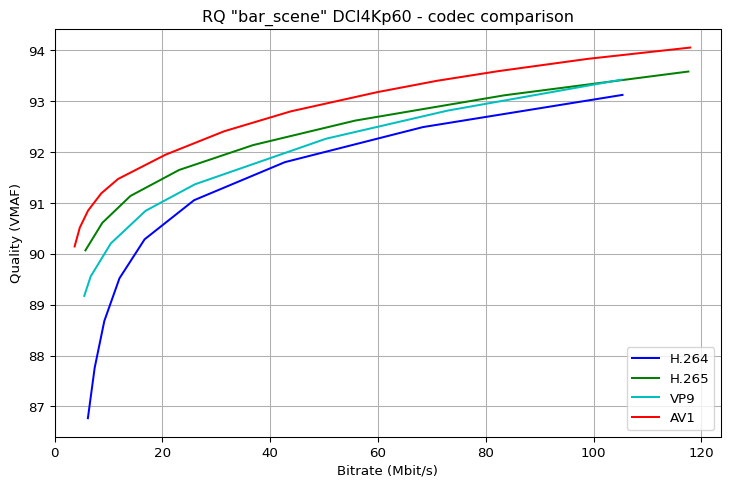

<Figure size 432x288 with 0 Axes>

In [236]:
plot = {"a": True, "b": True, "c": True, "d": True}

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)

if plot["a"]:
    rate = np.array([1.05353709e+08, 6.83631020e+07, 4.27482530e+07, 2.58863120e+07, 1.67122040e+07, 
                     1.20478740e+07, 9.24241200e+06, 7.45041000e+06, 6.18904000e+06])
    dist = np.array([93.123207, 92.491213, 91.802142, 91.053757, 90.285068, 89.519211, 88.682082, 87.760759, 
                     86.76965 ])
    pl.plot(rate/1000000, dist, '-b', label="H.264")

if plot["b"]:
    rate = np.array([1.17575223e+08, 8.34799270e+07, 5.57694190e+07, 3.68536940e+07, 
                     2.31076410e+07, 1.40871200e+07, 8.86047400e+06,5732370.])
    dist = np.array([93.582491, 93.116004, 92.618388, 92.137415, 91.647705, 91.13763, 90.608055,90.068154])
    pl.plot(rate/1000000, dist, '-g', label="H.265")

if plot["c"]:
    rate = np.array([1.05193904e+08, 7.29329000e+07, 5.03416170e+07, 2.60353530e+07, 
                     1.68783480e+07, 1.04460710e+07, 6.70851600e+06,5517571.])
    dist = np.array([93.422987, 92.814744, 92.261316, 91.365615, 90.844387, 90.204508, 89.555692,89.173762])
    pl.plot(rate/1000000, dist, '-c', label="VP9")

if plot["d"]:
    rate = np.array([1.1792057e+08, 9.8929090e+07, 8.2303776e+07, 7.0985200e+07, 59916656., 43797604., 
                     31459640., 20598245., 11777953.,  8669534.,  6221886., 4687235., 3.7298970e+06])
    dist = np.array([94.053456, 93.831756, 93.589965, 93.401327, 93.178479, 92.798971, 92.408155, 91.94848,
                     91.470458, 91.188183, 90.849231, 90.514643, 90.144644])
    pl.plot(rate/1000000, dist, '-r', label="AV1")

bpl.grid(True)
pl.xlim(xmin=0)
pl.title("RQ \"bar_scene\" DCI4Kp60 - codec comparison")
pl.ylabel("Quality (VMAF)")
pl.xlabel("Bitrate (Mbit/s)")
pl.legend(loc="lower right")
pl.figure()

-combine: comparing 625 options...
982410.9784951892 13.570862426626004


<Figure size 432x288 with 0 Axes>

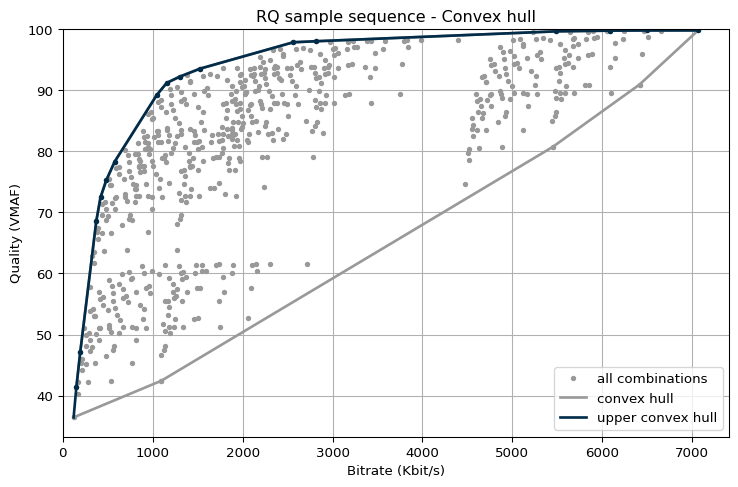

<Figure size 432x288 with 0 Axes>

In [229]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]
shot_index = 0

s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
opt_crfs = combine(s_crfs, "rate", 1000000) #create all combinations
xn = rate/1000
yn = 100-dist
points = np.zeros((len(xn),2))
for i in range(len(xn)):
    points[i] = [xn[i],yn[i]]
hull = ConvexHull(points)
pl.plot(xn, yn,'.', color="0.6",label="all combinations")
pl.plot(points[hull.vertices,0], points[hull.vertices,1], '-',color="0.6", lw=2,label="convex hull")
pl.plot(points[hull.vertices,0], points[hull.vertices,1], '.',color="0.6")
pl.plot(points[hull.vertices[4:],0], points[hull.vertices[4:],1], '-',color="#002b49", lw=2,label="upper convex hull")
pl.plot([points[hull.vertices[-1],0],points[hull.vertices[0],0]],
        [points[hull.vertices[-1],1],points[hull.vertices[0],1]], '-',color="#002b49", lw=2)
pl.plot(points[hull.vertices[4:],0], points[hull.vertices[4:],1], '.',color="#002b49")
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymax=100)
pl.title("RQ sample sequence - Convex hull")
pl.ylabel("Quality (VMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="lower right")
pl.figure()

-assessed= tests_vids/OPT_vids/.old/10sec_25/fx_rate/mux_10sec_rate05000fx_AVC.mp4
[73.087314 74.048242 74.16183  ... 69.988558 68.472914 66.216194]
-assessed= tests_vids/OPT_vids/.old/10sec_25/lg_rate/mux_10sec_rate05000lg_AVC.mp4
[73.087314 74.048242 74.16183  ... 66.669754 64.640768 62.592276]
-assessed= tests_vids/OPT_vids/.old/10sec_25/cf_rate/mux_10sec_rate05000cf_AVC.mp4
[75.837947 76.829096 77.234339 ... 66.669754 64.640768 62.592276]


<Figure size 432x288 with 0 Axes>

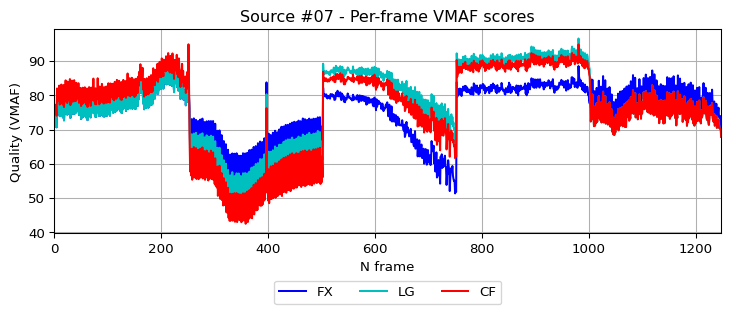

<Figure size 432x288 with 0 Axes>

In [412]:
#Per arricchire i grafici, anche in vista della tesi e della presentazione finale, 
#tracci il valore del VMAF nel tempo (cioe' vs numero del frame) per le varie tecniche, 
#per un caso significativo di differenza, possibilmente allo stesso bitrate o quasi, 
#in un punto con pendenza circa 45° (es. 800-1000 sul 720p). 
#Cosi' si vede se si guadagna principalmente in qualche shot o in tutte.

def perframe_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]scale={res[0]}x{res[1]}:flags=bicubic,setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs3.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs3.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    arr = np.zeros(len(i_data["frames"]))
    
    for f in i_data["frames"]:
        arr[f["frameNum"]] = f["metrics"]["vmaf"]
    return arr

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)

res = [1920,1080]
f_ref = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_FullHD/rush_field_cuts_1080p.y4m"
files = {"labels": ["FX","BF","LG","CF"], "colors": ["-b","-g","-c","-r"], 
         "files":["tests_vids/OPT_vids/rush_AVC/fx_rate/rush_fiel_rate15000fx_AVC.mp4",
                  "",
                  "tests_vids/OPT_vids/rush_AVC/lg_rate/rush_fiel_rate15000lg_AVC.mp4",
                  "tests_vids/OPT_vids/rush_AVC/cf_rate/rush_fiel_rate15000cf_AVC.mp4"]}

for i in range(4):
    if files["files"][i] != "":
        y = perframe_vmaf(files["files"][i],f_ref)
        print(y)
        x = np.arange(1,len(y)+1,dtype=int)
        pl.plot(x, y, files["colors"][i], label=files["labels"][i])

pl.title("Source #03 - Per-frame VMAF scores")
pl.ylabel("Quality (VMAF)")
pl.xlabel("N frame")
pl.xlim(xmin=0,xmax=av_x[-1])
pl.legend(bbox_to_anchor=(0.5, -0.35), loc="lower center", borderaxespad=0, ncol=3)
pl.grid(True)
pl.figure()

-assessed= tests_vids/OPT_vids/rush_AVC/fx_rate/rush_fiel_rate08000fx_AVC.mp4
-assessed= tests_vids/OPT_vids/rush_AVC/lg_rate/rush_fiel_rate08000lg_AVC.mp4
-assessed= tests_vids/OPT_vids/rush_AVC/cf_rate/rush_fiel_rate08000cf_AVC.mp4


<Figure size 432x288 with 0 Axes>

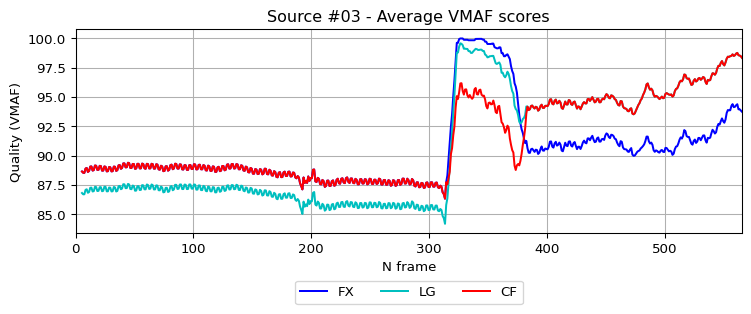

<Figure size 432x288 with 0 Axes>

In [416]:
def perframe_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs4.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs4.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    arr = np.zeros(len(i_data["frames"]))
    
    for f in i_data["frames"]:
        arr[f["frameNum"]] = f["metrics"]["vmaf"]
    return arr

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)

window = 10
f_ref = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_SD/rush_field_cuts_SDp.y4m"
files = {"labels": ["FX","BF","LG","CF"], "colors": ["-b","-g","-c","-r"], 
         "files":["tests_vids/OPT_vids/rush_AVC/fx_rate/rush_fiel_rate08000fx_AVC.mp4",
                  "",
                  "tests_vids/OPT_vids/rush_AVC/lg_rate/rush_fiel_rate08000lg_AVC.mp4",
                  "tests_vids/OPT_vids/rush_AVC/cf_rate/rush_fiel_rate08000cf_AVC.mp4"]}

for i in range(4):
    if files["files"][i] != "":
        y = perframe_vmaf(files["files"][i],f_ref)
        x = np.arange(1,len(y)+1,dtype=int)
        av_y = []
        av_x = []
        for ind in range(len(y) - window + 1):
            av_y.append(np.mean(y[ind:ind+window]))
            av_x.append(np.mean(x[ind:ind+window]))
        pl.plot(av_x, av_y, files["colors"][i], label=files["labels"][i])

pl.title("Source #03 - Average VMAF scores")
pl.ylabel("Quality (VMAF)")
pl.xlabel("N frame")
pl.xlim(xmin=0,xmax=av_x[-1])
pl.legend(bbox_to_anchor=(0.5, -0.35), loc="lower center", borderaxespad=0, ncol=3)
pl.grid(True)
pl.figure()

In [29]:
print(100-19.1959643450234)
print(80.858338)
print(197+121+60+102+90)

80.8040356549766
80.858338
570


-assessed= tests_vids/OPT_vids/mux_10sec_vmaf78lg_AVC.mp4
-assessed= tests_vids/temp_encoded/0/32_AVC.mp4
-assessed= tests_vids/temp_encoded/1/32_AVC.mp4
-assessed= tests_vids/temp_encoded/2/28_AVC.mp4
-assessed= tests_vids/temp_encoded/3/28_AVC.mp4
-assessed= tests_vids/temp_encoded/4/32_AVC.mp4


[Parsed_libvmaf_2 @ 0x557bcdf4ab80] input width must match.
[Parsed_libvmaf_2 @ 0x557bcdf4ab80] input height must match.
[Parsed_libvmaf_2 @ 0x557bcdf4ab80] Failed to configure input pad on Parsed_libvmaf_2
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #1:0
[Parsed_libvmaf_2 @ 0x55683f0e7d80] input width must match.
[Parsed_libvmaf_2 @ 0x55683f0e7d80] input height must match.
[Parsed_libvmaf_2 @ 0x55683f0e7d80] Failed to configure input pad on Parsed_libvmaf_2
Error reinitializing filters!
Failed to inject frame into filter network: Invalid argument
Error while processing the decoded data for stream #1:0
tests_vids/temp_encoded/2/28_AVC.mp4: No such file or directory
tests_vids/temp_encoded/3/28_AVC.mp4: No such file or directory
tests_vids/temp_encoded/4/32_AVC.mp4: No such file or directory


ValueError: x and y must have same first dimension, but have shapes (1252,) and (6260,)

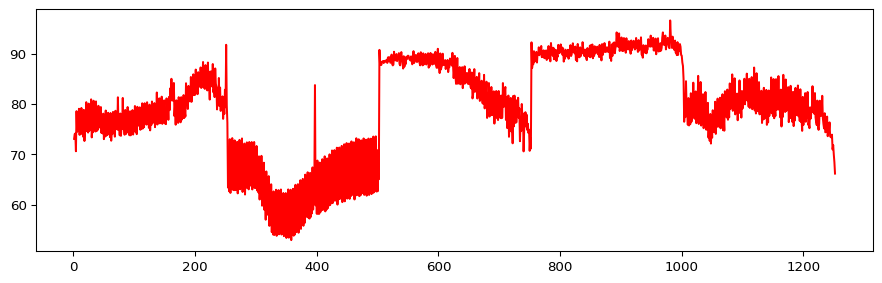

In [230]:
def perframe_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs4.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs4.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    arr = np.zeros(len(i_data["frames"]))
    
    for f in i_data["frames"]:
        arr[f["frameNum"]] = f["metrics"]["vmaf"]
    return arr

my_dpi = 96
pl.figure(figsize=(1080/my_dpi, 320/my_dpi), dpi=my_dpi)

window = 10
f_ref = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_FullHD/SVT/mux_10sec_25.y4m"
f_refs = ["tests_vids/srcRAW_FullHD/SVT/shot_0.y4m","tests_vids/srcRAW_FullHD/SVT/shot_1.y4m",
         "tests_vids/srcRAW_FullHD/SVT/shot_2.y4m","tests_vids/srcRAW_FullHD/SVT/shot_3.y4m","tests_vids/srcRAW_FullHD/SVT/shot_4.y4m"]
f_dist = "tests_vids/OPT_vids/mux_10sec_vmaf78lg_AVC.mp4"
f_dists = ["tests_vids/temp_encoded/0/32_AVC.mp4",
                  "tests_vids/temp_encoded/1/32_AVC.mp4",
                  "tests_vids/temp_encoded/2/28_AVC.mp4",
                  "tests_vids/temp_encoded/3/28_AVC.mp4",
                  "tests_vids/temp_encoded/4/32_AVC.mp4"]

y = perframe_vmaf(f_dist,f_ref)
x = np.arange(1,len(y)+1,dtype=int)
pl.plot(x, y, "-r", label="on the entire sequence")
ys = np.empty(0)
for i in range(5):
    ys = np.append(ys, perframe_vmaf(f_dists[i],f_refs[i]))
pl.plot(x, ys, "-b", label="on each shot separately")
print(y[0],ys[0])
print("-------")
print(y[251],ys[251])
print("-------")
print(y[501],ys[501])
print("-------")
print(y[751],ys[751])
print("-------")
print(y[1001],ys[1001])
pl.title("Source #14 SD AVC - motion")
pl.ylabel("Quality (VMAF)")
pl.xlabel("N frame")
pl.xlim(xmin=0,xmax=x[-1])
pl.legend(bbox_to_anchor=(0.5, -0.35), loc="lower center", borderaxespad=0, ncol=3)
pl.grid(True)
pl.figure()

In [123]:
def perframe_vmaf(dist,ref):
    c_vmaf = f"ffmpeg -i {ref} -i {dist} -hide_banner -loglevel error\
            -lavfi \"[0:v]setpts=PTS-STARTPTS[ref];\
                    [1:v]setpts=PTS-STARTPTS[dist];\
                    [dist][ref]libvmaf=feature=name=psnr:log_path=config/vmaf_logs4.json:log_fmt=json\" \
            -f null -" #|name=float_ssim|name=float_ms_ssim to compute the other metrics
    subprocess.call(c_vmaf, shell=True)
    print("-assessed= " + dist)
    with open("config/vmaf_logs4.json", 'r') as r: #extract quality and rate values
        i_data = json.load(r)
    return i_data["pooled_metrics"]["vmaf"]["mean"]

my_dpi = 96
pl.figure(figsize=(1080/my_dpi, 320/my_dpi), dpi=my_dpi)

window = 10
f_ref = "/home/ubuntu/video_dynopt/tests_vids/srcRAW_FullHD/SVT/mux_10sec_25.y4m"
f_refs = ["tests_vids/srcRAW_FullHD/SVT/shot_0.y4m","tests_vids/srcRAW_FullHD/SVT/shot_1.y4m",
         "tests_vids/srcRAW_FullHD/SVT/shot_2.y4m","tests_vids/srcRAW_FullHD/SVT/shot_3.y4m","tests_vids/srcRAW_FullHD/SVT/shot_4.y4m"]
f_dist = "tests_vids/OPT_vids/mux_10sec_vmaf78lg_AVC.mp4"
f_dists = ["tests_vids/temp_encoded/0/32_AVC.mp4",
                  "tests_vids/temp_encoded/1/32_AVC.mp4",
                  "tests_vids/temp_encoded/2/28_AVC.mp4",
                  "tests_vids/temp_encoded/3/28_AVC.mp4",
                  "tests_vids/temp_encoded/4/32_AVC.mp4"]
print(perframe_vmaf(f_dist,f_ref))
ys = np.empty(0)
for i in range(5):
    print(perframe_vmaf(f_dists[i],f_refs[i]))
#pl.plot(x, ys, "-b", label="on each shot separately")

-assessed= tests_vids/OPT_vids/mux_10sec_vmaf78lg_AVC.mp4
79.262987
-assessed= tests_vids/temp_encoded/0/32_AVC.mp4
78.61873
-assessed= tests_vids/temp_encoded/1/32_AVC.mp4
63.712663
-assessed= tests_vids/temp_encoded/2/28_AVC.mp4
84.441588
-assessed= tests_vids/temp_encoded/3/28_AVC.mp4
90.724668
-assessed= tests_vids/temp_encoded/4/32_AVC.mp4
78.675433


<Figure size 1080x320 with 0 Axes>

In [124]:

print((78.61873+63.712663+84.441588+90.724668+78.675433)/5)

79.2346164


# Brute Force

In [194]:
import numpy as np #easy vector operations
import matplotlib.pyplot as pl #to display plots
import os #to access system folders
import json #to handle json files
import itertools #to combine options
import numpy as np #easy vector operations
import math #for operation with infinite
import copy #to create list shadow copies
import subprocess #to access ffmpeg in the system

def combine(sc, tn, tv):
    """
    Create all encoded points possible combinations and find the closest to the target
    
    Output:
    - o : list (num_shots)
        Best CRF combination for the current target
    """
    o = []
    if tn == "rate":
        y_min = 100
        to_min = "dist"
        xf, xg, yf, yg = 0, -1, 100, 1
    elif tn == "dist":
        y_min = math.inf
        to_min = "rate"
        xf, xg, yf, yg = 100, 1, 0, -1
    print("-combine: comparing " + str(np.shape(sc)[1]**np.shape(sc)[0]) + " options...")
    tmp = 0
    for comb in itertools.product(*sc): #for each combination
        x = y = 0
        for i,val in enumerate(comb):
            x += (xf-xg*data["shots"][i]["assessment"][tn][val]) * data["shots"][i]["duration"]
            y += (yf-yg*data["shots"][i]["assessment"][to_min][val]) * data["shots"][i]["duration"]
        x = x / duration
        y = y / duration
        rate[tmp] = x
        dist[tmp] = y
        tmp += 1
        if x < tv and y < y_min:
            y_min = y
            o = list(comb)
            x_min = x
    print(x_min,y_min)
    if not o:
        if tn == "rate":
            print("no encodings satisfy the target - encoding at min quality")
            o = list(comb)
        elif tn == "dist":
            print("no encodings satisfy the target - encoding at max quality")
            o = np.zeros(num_shots,dtype=int) + 10
    return o

idu = f"ffprobe -v error -select_streams v:0 -show_entries format:stream \
    -print_format json tests_vids/srcRAW_SD/rush_field_cuts_SDp.y4m -hide_banner -loglevel error"
dta = json.loads(subprocess.run(idu.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout)
duration = float(dta['format']['duration'])
rate = np.zeros(np.shape(s_crfs)[1]**np.shape(s_crfs)[0])
dist = np.zeros(np.shape(s_crfs)[1]**np.shape(s_crfs)[0])
    
with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]
shot_index = 0

s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1

-combine: comparing 625 options...
982410.9784951892 13.570862426626004


<Figure size 432x288 with 0 Axes>

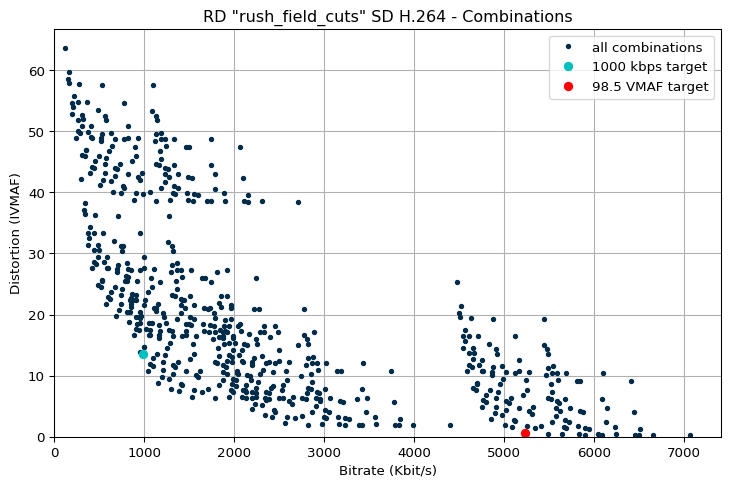

<Figure size 432x288 with 0 Axes>

In [286]:
with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]
shot_index = 0

s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1
    
my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
opt_crfs = combine(s_crfs, "rate", 1000000) #create all combinations
pl.plot(rate/1000, dist,'.', color="#002b49",label="all combinations")
pl.plot(982.5709015195331, 13.567843268836427,'co', label="1000 kbps target")
pl.plot(5231.857172091067, 0.5482212963878228,'ro', label="98.5 VMAF target")
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.title("RD \"rush_field_cuts\" SD H.264 - Combinations")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

-combine: comparing 625 options...
982410.9784951892 13.570862426626004


<Figure size 432x288 with 0 Axes>

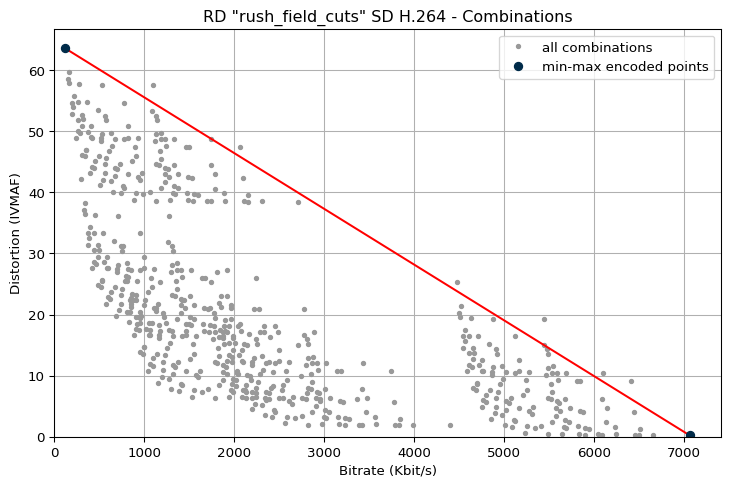

<Figure size 432x288 with 0 Axes>

In [294]:
with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]
shot_index = 0

s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1
    
my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
opt_crfs = combine(s_crfs, "rate", 1000000) #create all combinations
pl.plot(rate/1000, dist,'.',color="0.6", label="all combinations")
pl.plot([rate[0]/1000,rate[-1]/1000], [dist[0],dist[-1]],'-r')
pl.plot([rate[0]/1000,rate[-1]/1000], [dist[0],dist[-1]],'o',color="#002b49", label="min-max encoded points")
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.title("RD \"rush_field_cuts\" SD H.264 - Combinations")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

-combine: comparing 625 options...
982410.9784951892 13.570862426626004


<Figure size 432x288 with 0 Axes>

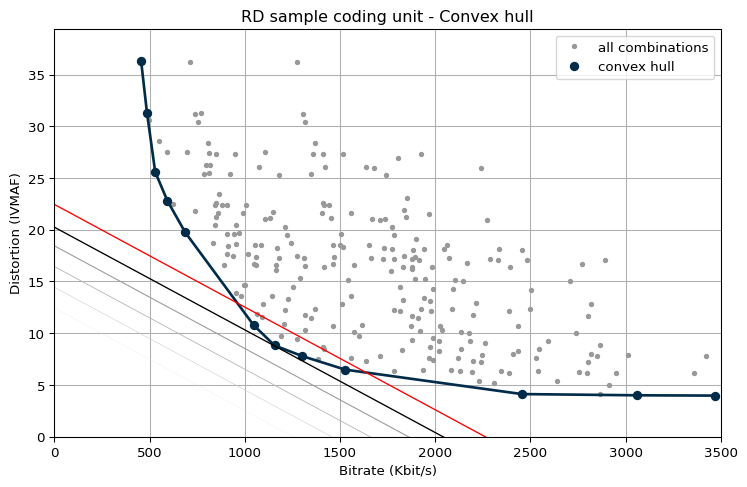

<Figure size 432x288 with 0 Axes>

In [307]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
def line(x, x1, y1):
    return -0.009921710209728224*(x - x1) + y1

with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]
shot_index = 0

s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
opt_crfs = combine(s_crfs, "rate", 1000000) #create all combinations
xn = rate[200:450]/1000
yn = dist[200:450]
rng = np.random.default_rng()
points = np.zeros((len(xn),2))
for i in range(len(xn)):
    points[i] = [xn[i],yn[i]]
hull = ConvexHull(points)
pl.plot(xn, yn,'.', color="0.6",label="all combinations")
pl.plot(points[hull.vertices[1:-3],0], points[hull.vertices[1:-3],1], '-',color="#002b49", lw=2)
pl.plot(points[hull.vertices[1:-3],0], points[hull.vertices[1:-3],1], 'o',color="#002b49",label="convex hull")

xrange = np.linspace(1254.477-2500, 1254.477+2500, 2)
pl.plot(xrange, line(xrange, 1254.477, 10), 'r-', linewidth = 1)
pl.plot(xrange, line(xrange, 1254.477, 7.8), '-',color="0", linewidth = 1)
pl.plot(xrange, line(xrange, 1254.477, 6), '-',color=".6", linewidth = 0.8)
pl.plot(xrange, line(xrange, 1254.477, 4), '-',color=".7", linewidth = 0.6)
pl.plot(xrange, line(xrange, 1254.477, 2), '-',color=".8", linewidth = 0.4)
pl.plot(xrange, line(xrange, 1254.477, 0), '-',color=".9", linewidth = 0.2)
pl.grid(True)
pl.xlim(xmin=0,xmax=3500)
pl.ylim(ymin=0)
pl.title("RD sample coding unit - Convex hull")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

# Lagrange convergence

-combine: comparing 625 options...
982410.9784951892 13.570862426626004


<Figure size 432x288 with 0 Axes>

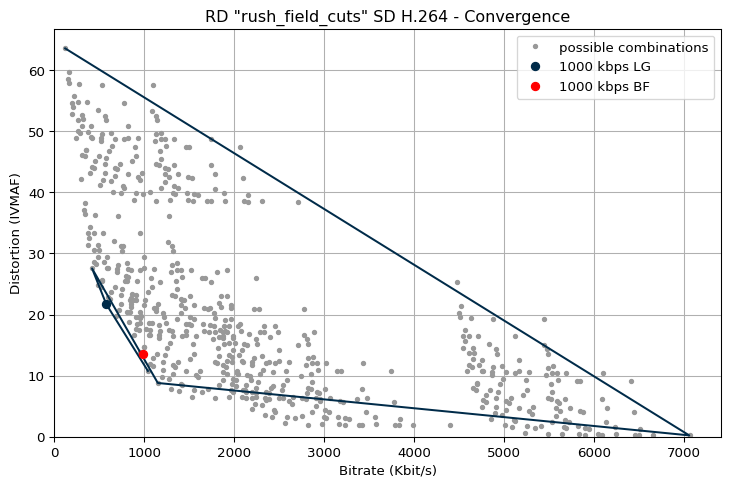

<Figure size 432x288 with 0 Axes>

In [290]:
import numpy as np #easy vector operations
import matplotlib.pyplot as pl #to display plots
import os #to access system folders
import json #to handle json files
import itertools #to combine options
import numpy as np #easy vector operations
import math #for operation with infinite
import copy #to create list shadow copies
import subprocess #to access ffmpeg in the system

def compute_slope(xl,yl,xr,yr):
    return -(yl-yr)/(xl-xr)

idu = f"ffprobe -v error -select_streams v:0 -show_entries format:stream \
    -print_format json tests_vids/srcRAW_SD/rush_field_cuts_SDp.y4m -hide_banner -loglevel error"
dta = json.loads(subprocess.run(idu.split(), stdout=subprocess.PIPE, stderr=subprocess.STDOUT).stdout)
duration = float(dta['format']['duration'])
    
with open("tests_rd/rush_field_cuts_SDp.json", 'r') as f:
    data = json.load(f)
num_shots = len(data["shots"])
npts = [10,18,25,32,40]

shot_index = 0
s_crfs = np.zeros((num_shots, len(npts)), dtype=int) #init structure
for shot in range(0,4): #for each shot
    s_crfs[shot_index] = [c for c in data["shots"][shot_index]["assessment"]["crf"] if c != 0]
    shot_index += 1

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
opt_crfs = combine(s_crfs, "rate", 1000000) #create all combinations
pl.plot(rate/1000, dist,'.',color="0.6", label="possible combinations")
pl.plot([120,7060,1150,419,577,1040], [63.56,0.22,8.8,27.54,21.69,10.77],'-',color="#002b49")
pl.plot(577, 21.69,'o',color="#002b49",label="1000 kbps LG")
pl.plot(982, 13.57,'ro',label="1000 kbps BF")
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.title("RD \"rush_field_cuts\" SD H.264 - Convergence")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

0.009121710209728224


<Figure size 432x288 with 0 Axes>

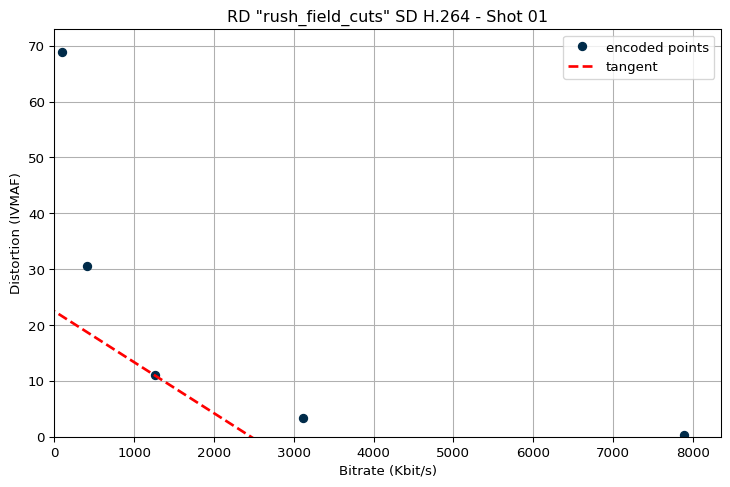

<Figure size 432x288 with 0 Axes>

In [280]:
def line(x, x1, y1):
    return -0.009121710209728224*(x - x1) + y1
rate = np.asarray([c for c in data["shots"][0]["assessment"]["rate"] if c != 0])
dist = np.asarray([c for c in data["shots"][0]["assessment"]["dist"] if c != 0])

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
pl.plot(rate/1000, 100-dist,'o',color="#002b49", label="encoded points")
xrange = np.linspace(1254.477-2500, 1254.477+2500, 2)
pl.plot(xrange, line(xrange, 1254.477, 100-88.985674), 'r--', linewidth = 2, label="tangent")
print(compute_slope(120.6892143645828,63.5690251574741,7064.945390451655,0.22553269709237944))
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.title("RD \"rush_field_cuts\" SD H.264 - Shot 01")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

# Curve fitting performances

<Figure size 432x288 with 0 Axes>

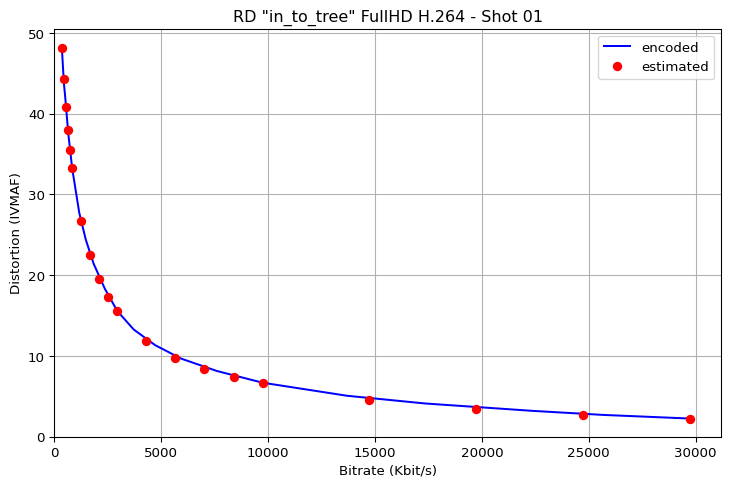

<Figure size 432x288 with 0 Axes>

In [234]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import shutil #to remove directories
import numpy as np #easy vector operations
import math #for operation with infinite
import itertools #to combine options
import copy #to create list shadow copies
import json #to handle json files
import matplotlib.pyplot as pl #to display plots
import tkinter as tk #to import files
from tkinter import filedialog #to open import dialog box
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def eq_fit(x, a, b, c):
    return a / (x + b) + c

def expand(x,y,i,p):
    #number of points in between two init points
    ti = crf[i+1] - crf[i] + 1
    #ti linearly spaced numbers within the interval
    tx = np.linspace(x[i],x[i+1],num=ti,endpoint=True)
    #linear interpolation of points
    ty = eq_fit(tx,*p)
    #cumulative trapezoid (n order) integrated value of ty(tx)
    cdf = cumtrapz(ty, tx, initial=0)
    #normalize [0,1]
    cdf *= (1/cdf[-1])
    #approximated function from tx points according to its distribution function
    intfunc = interp1d(cdf, tx, fill_value="extrapolate")
    #new x points
    o = intfunc(np.linspace(0, 1, ti, endpoint=True))
    return o[:-1]

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
rate_enc = np.array([29711940, 25670713, 22361838, 17333372, 13687444,  9740388, 7607728, 5929433, 4716482, 3707288, 2940000,  2363058,  1836107, 1465541, 1163144, 831104, 649654, 495527, 446572, 348727])
dist_enc = 100-np.array([97.745404, 97.297729, 96.794987, 95.879349, 94.925449, 93.308427, 91.86421, 90.32445,  88.664915, 86.714368, 84.420302, 81.689808, 78.579636, 75.56556, 72.265885, 66.738389, 62.447092, 57.61668,  56.309302, 51.808674])
crf = [0,5,10,15,19]
p_r = rate_enc[crf]
p_d = dist_enc[crf]

par, cov = curve_fit(eq_fit, p_r, p_d, bounds=((0,-np.inf,0),np.inf)) #fitting
x = np.flip(p_r)
xnew = np.append(np.concatenate([expand(x,p_d,i,par) for i in range(len(crf)-1)]),x[-1])
y = p_d
ynew = np.append(np.concatenate([np.interp(eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par),
    (eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par).min(),
    eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par).max()),
    (y[len(crf)-i-2],y[len(crf)-i-1]))[:-1] for i in range(len(crf)-1)]),y[0])

pl.plot(rate_enc/1000, dist_enc, '-b', label="encoded")
pl.plot(xnew/1000, ynew, '-r', label="estimated")
pl.grid(True)
pl.xlim(xmin=0)
pl.ylim(ymin=0)
pl.title("RD \"in_to_tree\" FullHD H.264 - Shot 01")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

<Figure size 432x288 with 0 Axes>

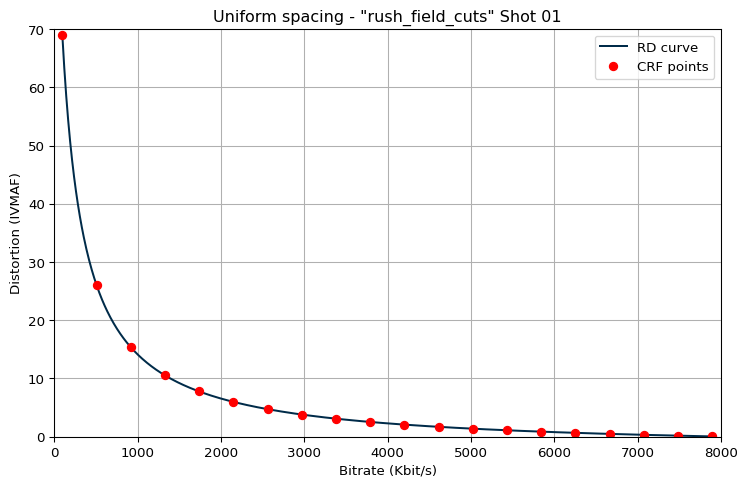

<Figure size 432x288 with 0 Axes>

In [47]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import shutil #to remove directories
import numpy as np #easy vector operations
import math #for operation with infinite
import itertools #to combine options
import copy #to create list shadow copies
import json #to handle json files
import matplotlib.pyplot as pl #to display plots
import tkinter as tk #to import files
from tkinter import filedialog #to open import dialog box
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def eq_fit(x, a, b, c):
    return a / (x + b) + c

def expand(x,y,i,p):
    #number of points in between two init points
    ti = crf[i+1] - crf[i] + 1
    #ti linearly spaced numbers within the interval
    tx = np.linspace(x[i],x[i+1],num=ti,endpoint=True)
    #linear interpolation of points
    ty = eq_fit(tx,*p)
    #cumulative trapezoid (n order) integrated value of ty(tx)
    cdf = cumtrapz(ty, tx, initial=0)
    #normalize [0,1]
    cdf *= (1/cdf[-1])
    #approximated function from tx points according to its distribution function
    intfunc = interp1d(cdf, tx, fill_value="extrapolate")
    #new x points
    o = intfunc(np.linspace(0, 1, ti, endpoint=True))
    return o[:-1]

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
xr = np.array([588466103,490635637,461406883,432371159,402672470,372375988,341669644,309944347,277518532,245761096,
 214736104,185733148,159040080,134108196,111589987,92030236,74726300,60065085,47836972,37010096,27628087,
 20446353,15116993,11495500,9032000,7334293,6064209,5074938,4278792,3630300,3091694,2644935,2271268,
 1969874,1719907,1531354,1359375,1225185,1108488,1001439,905161,812926,728488,655371,579448,508360,438272,
 369922,299612,237527,200602,174114])
yd = 100-np.array([99.994855,99.994263,99.994213,99.993923,99.992449,99.986786,99.969278,99.933396,99.871804,99.774042,
99.614432,99.342061,98.950756,98.432613,97.816404,97.15618,96.487038,95.761609,94.967031,94.114446,
93.192421,92.150132,90.986222,89.661067,88.134627,86.305212,84.169581,81.790557,79.009241,75.897074,
72.307432,68.346252,64.041025,59.170603,54.303465,49.436693,44.383772,39.709942,35.206264,31.020645,
27.784484,24.813072,22.553462,19.881537,18.005095,16.583772,14.969791,13.264948,11.813389,10.209801,
9.185123,8.364765])
rate_enc = np.array([29711940, 25670713, 22361838, 17333372, 13687444,  9740388, 7607728, 5929433, 4716482, 3707288, 2940000,  2363058,  1836107, 1465541, 1163144, 831104, 649654, 495527, 446572, 348727])
dist_enc = 100-np.array([97.745404, 97.297729, 96.794987, 95.879349, 94.925449, 93.308427, 91.86421, 90.32445,  88.664915, 86.714368, 84.420302, 81.689808, 78.579636, 75.56556, 72.265885, 66.738389, 62.447092, 57.61668,  56.309302, 51.808674])
cmp = {'rate': np.array([[7894634., 3112564., 1254477.,  414777.,   95344.],
       [9452621., 4096383., 1680954.,  640619.,  197328.],
       [5554681., 2178453.,  916086.,  388947.,  147226.],
       [4246505., 1648577.,  729488.,  324482.,  128924.]]),
       'dist': np.array([[3.7449500e-01, 3.2755960e+00, 1.1014326e+01, 3.0574770e+01,
        6.8948268e+01],
       [5.2583000e-02, 1.1780400e-01, 1.7177010e+00, 2.0296656e+01,
        5.6965370e+01],
       [3.0934000e-02, 6.9047500e-01, 7.9802920e+00, 2.5134300e+01,
        5.7188043e+01],
       [3.4959000e-02, 2.2034700e-01, 6.7303290e+00, 2.4419002e+01,
        5.6138310e+01]])}
crf = [15,20,25,30,35]
p_r = cmp["rate"][0]
p_d = cmp["dist"][0]

par, cov = curve_fit(eq_fit, p_r, p_d) #fitting
x = np.flip(p_r)
tx = np.linspace(x[0],x[-1],num=1000,endpoint=True)
tx2 = np.linspace(x[0],x[-1],num=20,endpoint=True)
xnew = np.append(np.concatenate([expand(x,p_d,i,par) for i in range(len(crf)-1)]),x[-1])
y = p_d
ty = eq_fit(tx,*par)
ty2 = eq_fit(tx2,*par)
#ynew = eq_fit(xnew,*par)
ynew = np.append(np.concatenate([np.interp(eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par),
                                    (eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par).min(),
                                     eq_fit(xnew[crf[i]-crf[0]:crf[i+1]-crf[0]+1],*par).max()),
                                     (y[len(crf)-i-2],y[len(crf)-i-1]))[:-1] for i in range(len(crf)-1)]),y[0])

#pl.plot(tx/1000, ty, '-r', label="fit()")
#pl.plot(xr[10:41]/1000, yd[10:41], '-',color="#002b49", label="encoded")
pl.plot(tx/1000, ty, '-', color="#002b49", label="RD curve")
pl.plot(tx2/1000, ty2, 'or', label="CRF points")
pl.grid(True)
pl.xlim(xmin=0,xmax=8000)
pl.ylim(ymin=0,ymax=70)
pl.title("Uniform spacing - \"rush_field_cuts\" Shot 01")
pl.ylabel("Distortion (IVMAF)")
pl.xlabel("Bitrate (Kbit/s)")
pl.legend(loc="upper right")
pl.figure()

<Figure size 432x288 with 0 Axes>

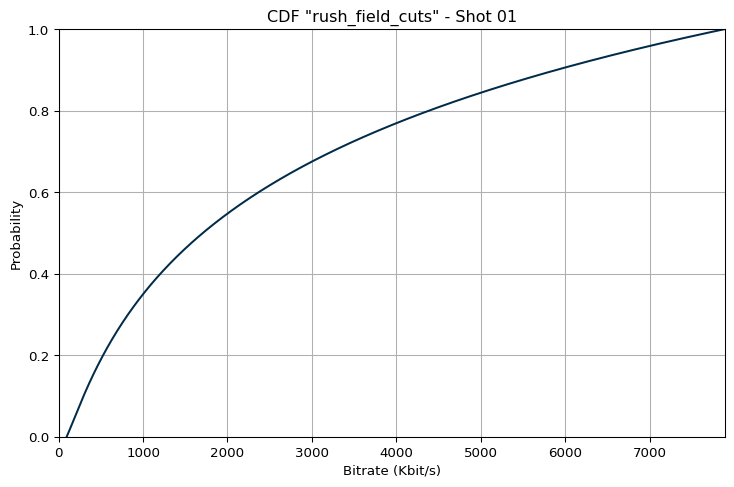

<Figure size 432x288 with 0 Axes>

In [32]:
def eq_fit(x, a, b, c):
    return a / (x + b) + c

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
cmp = {'rate': np.array([[7894634., 3112564., 1254477.,  414777.,   95344.],
       [9452621., 4096383., 1680954.,  640619.,  197328.],
       [5554681., 2178453.,  916086.,  388947.,  147226.],
       [4246505., 1648577.,  729488.,  324482.,  128924.]]),
       'dist': np.array([[3.7449500e-01, 3.2755960e+00, 1.1014326e+01, 3.0574770e+01,
        6.8948268e+01],
       [5.2583000e-02, 1.1780400e-01, 1.7177010e+00, 2.0296656e+01,
        5.6965370e+01],
       [3.0934000e-02, 6.9047500e-01, 7.9802920e+00, 2.5134300e+01,
        5.7188043e+01],
       [3.4959000e-02, 2.2034700e-01, 6.7303290e+00, 2.4419002e+01,
        5.6138310e+01]])}
p_r = cmp["rate"][0]
p_d = cmp["dist"][0]

par, cov = curve_fit(eq_fit, p_r, p_d) #fitting
x = np.flip(p_r)
tx = np.linspace(x[0],x[-1],num=1000,endpoint=True)
y = eq_fit(x,*par)
ty = eq_fit(tx,*par)

cdf = cumtrapz(tx,ty, initial=0)
cdf *= (1/cdf[-1])
pl.plot(tx/1000, cdf, '-', color="#002b49")
pl.grid(True)
pl.xlim(xmin=0,xmax=tx.max()/1000)
pl.ylim(ymin=0,ymax=1)
pl.title("CDF \"rush_field_cuts\" - Shot 01")
pl.ylabel("Probability")
pl.xlabel("Bitrate (Kbit/s)")
pl.figure()

# siti VQEG

In [ ]:
siti-tools /home/ubuntu/dynopt2/tests_vids/shots_10sec/scene0.y4m > /home/ubuntu/dynopt2/tests_vids/shots_10sec/SITIscene0.y4m

<Figure size 432x288 with 0 Axes>

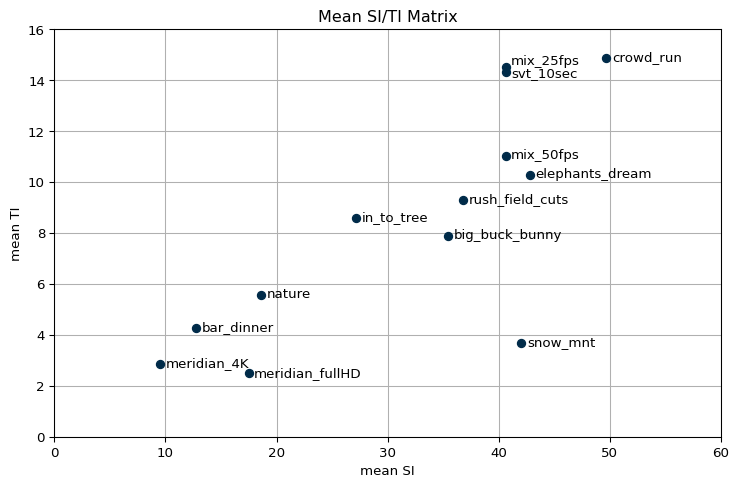

<Figure size 432x288 with 0 Axes>

In [55]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import numpy as np #easy vector operations
import math #for operation with infinite
import json #to handle json files
import matplotlib.pyplot as pl #to display plots

folder = "tests_vids/SITI_scores/"
num_sources = len(os.listdir(folder))
si = np.zeros(num_sources)
ti = np.zeros(num_sources)
source = np.empty(num_sources,dtype=object)

file_index = 0
for file in sorted(os.listdir(folder)):
    with open(folder + file, 'r') as f:
        data = json.load(f)
        si[file_index] = np.mean(data["si"])
        ti[file_index] = np.mean(data["ti"])
        source[file_index] = data["input_file"]
    file_index += 1

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
pl.plot(si,ti,'o',color="#002b49")
for i, txt in enumerate(source):
    if txt == "svt_10sec":
        pl.annotate(txt, (si[i]+0.5, ti[i]-0.2))
    elif txt == "mix_25fps":
        pl.annotate(txt, (si[i]+0.5, ti[i]+0.1))
    else:
        pl.annotate(txt, (si[i]+0.5, ti[i]-0.1))
pl.grid(True)
pl.xlim(xmin=0,xmax=60)
pl.ylim(ymin=0,ymax=16)
pl.title("Mean SI/TI Matrix")
pl.ylabel("mean TI")
pl.xlabel("mean SI")
pl.figure()

<Figure size 432x288 with 0 Axes>

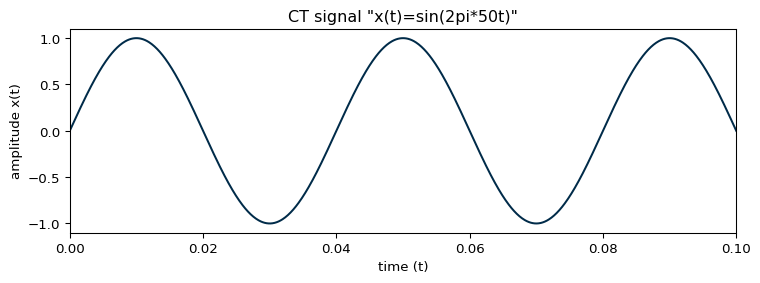

<Figure size 432x288 with 0 Axes>

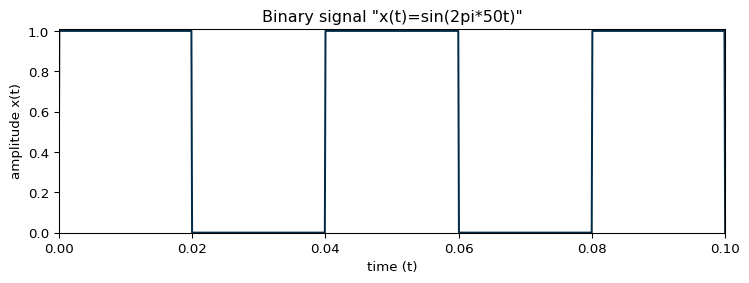

<Figure size 432x288 with 0 Axes>

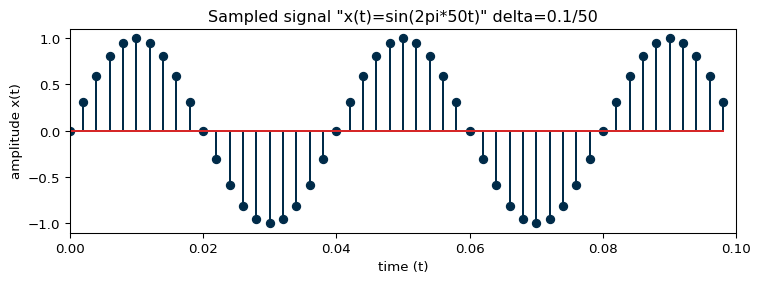

<Figure size 432x288 with 0 Axes>

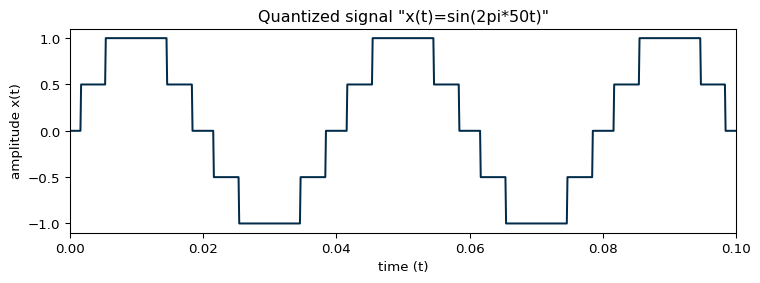

<Figure size 432x288 with 0 Axes>

In [387]:
# imports
import os #to access system folders
import sys #to exit the process
import subprocess #to access ffmpeg in the system
import numpy as np #easy vector operations
import math #for operation with infinite
import json #to handle json files
import matplotlib.pyplot as pl #to display plots

my_dpi = 96
pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)
t = np.linspace(0., 0.1, 1000)
pl.plot(t, np.sin(2*np.pi*25*t),color="#002b49")
pl.xlabel('time (t)')
pl.ylabel('amplitude x(t)')
pl.title("CT signal \"x(t)=sin(2pi*50t)\"")
pl.xlim([0., 0.1])
pl.figure()

pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)
t = np.linspace(0., 0.1, 1000)
sign = np.sin(2*np.pi*25*t)
bi = [1 if x > 0 else 0 for x in sign]
pl.plot(t, bi,color="#002b49")
pl.xlabel('time (t)')
pl.ylabel('amplitude x(t)')
pl.title("Binary signal \"x(t)=sin(2pi*50t)\"")
pl.xlim([0., 0.1])
pl.ylim([-0.0005, 1.01])
pl.figure()

pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)
n = np.arange(50)
dt = 0.1/50
x = np.sin(2 * np.pi * 25 * n * dt)
pl.xlabel('time (t)')
pl.ylabel('amplitude x(t)')
pl.title("Sampled signal \"x(t)=sin(2pi*50t)\" delta=0.1/50")
markerline, stemlines, _ = pl.stem(n*dt, x)
pl.setp(markerline, 'color', "#002b49")
pl.setp(stemlines, 'color', "#002b49")
pl.xlim([0., 0.1])
pl.figure()

pl.figure(figsize=(860/my_dpi, 270/my_dpi), dpi=my_dpi)
t = np.linspace(0., 0.1, 1000)
q = 0.5
sign = np.sin(2*np.pi*25*t)
y = q * np.round(sign/q)
pl.plot(t, y,color="#002b49")
pl.xlabel('time (t)')
pl.ylabel('amplitude x(t)')
pl.title("Quantized signal \"x(t)=sin(2pi*50t)\"")
pl.xlim([0., 0.1])
pl.figure()

In [351]:
print(1920 * 1080 * 25 * 8 + 2 * (960 * 1080 * 25 * 8))

829440000
